#  ARCH TECHNOLOGIES Internship Category B
# Brain Tumor Segmentation (BraTS2020) in Google Colab
**Using YOLO +SAM2**


## 1. Download and Prepare the BraTS2020 Dataset

In [2]:
import kagglehub
import shutil
import os

#Downloading the dataset using kagglehub
path = kagglehub.dataset_download("awsaf49/brats2020-training-data")
print("Dataset originally downloaded to:", path)

# Defining the destination path in Colab's sample_data
target_dir = "/content/sample_data/brats2020-training-data"

# Moving dataset to /content/sample_data/
if os.path.exists(target_dir):
    shutil.rmtree(target_dir)
shutil.copytree(path, target_dir)
print("Dataset moved to:", target_dir)

Dataset originally downloaded to: /kaggle/input/brats2020-training-data
Dataset moved to: /content/sample_data/brats2020-training-data


Keys: ['image', 'mask']
Image shape: (240, 240, 4)


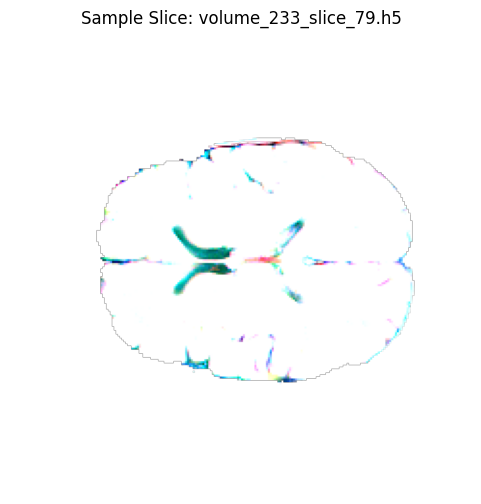

In [3]:

import h5py
import numpy as np
import matplotlib.pyplot as plt
import os

data_dir = "/content/sample_data/brats2020-training-data/BraTS2020_training_data/content/data"
sample_file = os.path.join(data_dir, os.listdir(data_dir)[0])  # Pick the first slice

with h5py.File(sample_file, 'r') as f:
    print("Keys:", list(f.keys()))
    # Extractin image
    image_data = f[list(f.keys())[0]][()]
    print("Image shape:", image_data.shape)

# Plotin the image
plt.figure(figsize=(6, 6))
plt.imshow(image_data, cmap='gray')
plt.title(f"Sample Slice: {os.path.basename(sample_file)}")
plt.axis('off')
plt.show()

# **2 . Project Structure Setup**

Modalities shape: (240, 240, 4) Mask shape: (240, 240, 3)


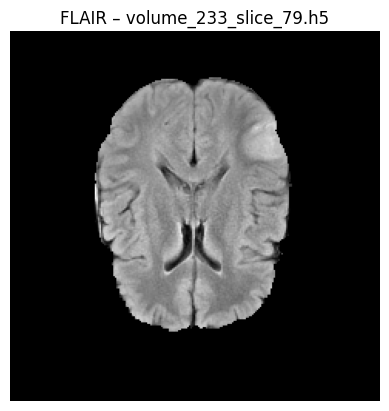

In [6]:
import h5py, numpy as np, matplotlib.pyplot as plt, os

data_dir   = "/content/sample_data/brats2020-training-data/BraTS2020_training_data/content/data"
sample_f   = os.listdir(data_dir)[0]
with h5py.File(os.path.join(data_dir, sample_f), 'r') as f:
    img4  = f['image'][:]   # (240×240×4)
    msk3  = f['mask'][:]
print("Modalities shape:", img4.shape, "Mask shape:", msk3.shape)

# show FLAIR (channel 0)
plt.imshow(img4[:,:,0].T, cmap='gray', origin='lower')
plt.title(f"FLAIR – {sample_f}")
plt.axis('off'); plt.show()


Build a 30% subset of filenames

In [7]:
import os, random
data_dir   = "/content/sample_data/brats2020-training-data/BraTS2020_training_data/content/data"
all_files  = [f for f in os.listdir(data_dir) if f.endswith('.h5')]
random.seed(42)
subset_files = random.sample(all_files, k=int(0.3 * len(all_files)))
print(f"Using {len(subset_files)} / {len(all_files)} files (~30%)")


Using 17158 / 57195 files (~30%)


Split into train/val

In [8]:
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(
    subset_files, test_size=0.3, random_state=42
)
print("Train:", len(train_files), "  Val:", len(val_files))


Train: 12010   Val: 5148


## Convert H5 → PNG & YOLO label files

In [9]:
import h5py, numpy as np, cv2

# where to dump YOLO data
base = "/content/data"
for sub in ["images/train","images/val","labels/train","labels/val"]:
    os.makedirs(os.path.join(base, sub), exist_ok=True)

def process_list(file_list, split):
    for fname in file_list:
        # read
        with h5py.File(os.path.join(data_dir, fname), "r") as f:
            vol4  = f["image"][:]   # H×W×4
            msk3  = f["mask"][:]    # H×W×3

        # extract FLAIR channel
        flair = vol4[:,:,0]
        # normalize & to uint8
        img = ((flair - flair.min())/(flair.max()-flair.min()+1e-6)*255).astype(np.uint8)

        # save PNG
        img_path = os.path.join(base, f"images/{split}/{fname[:-3]}.png")
        cv2.imwrite(img_path, img)

        # build YOLO label lines
        H,W = img.shape
        lines = []
        for cls in range(3):  # 0,1,2
            ys,xs = np.where(msk3[:,:,cls]>0)
            if ys.size:
                y0,y1 = ys.min(), ys.max()
                x0,x1 = xs.min(), xs.max()
                # normalized center, w,h
                cx = ((x0+x1)/2)/W
                cy = ((y0+y1)/2)/H
                w  = (x1-x0)/W
                h  = (y1-y0)/H
                lines.append(f"{cls} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}")

        # write .txt (even if empty for no‐tumor slices)
        lbl_path = os.path.join(base, f"labels/{split}/{fname[:-3]}.txt")
        with open(lbl_path, "w") as f:
            f.write("\n".join(lines))

# process
process_list(train_files, "train")
process_list(val_files,   "val")

print("Done converting to YOLO format.")


Done converting to YOLO format.


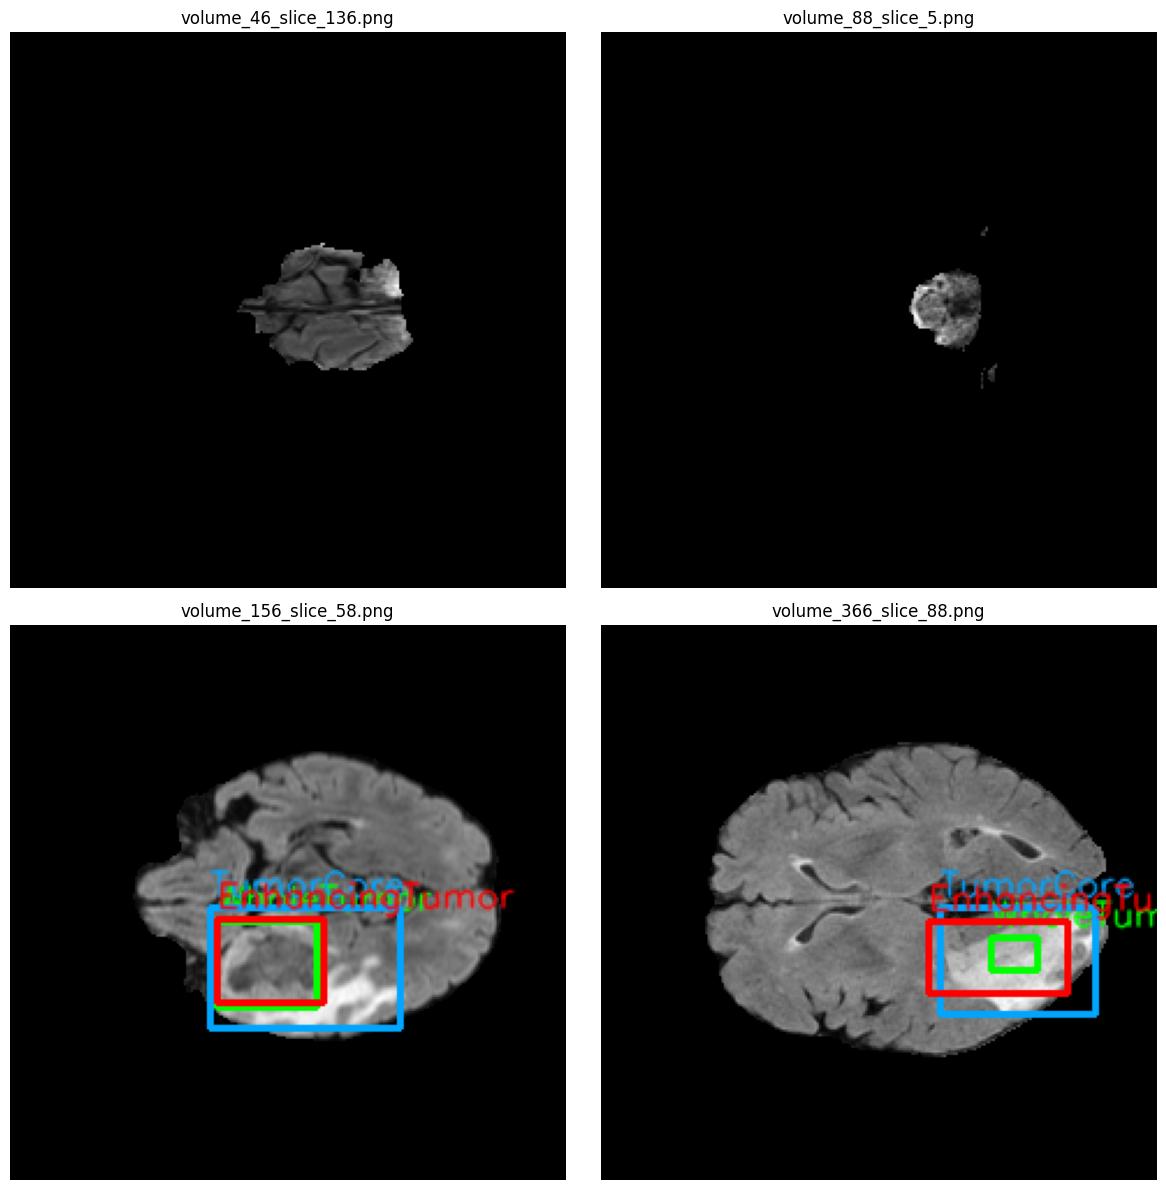

In [10]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Paths
img_dir = "/content/data/images/train"
lbl_dir = "/content/data/labels/train"
class_names = ['WholeTumor','TumorCore','EnhancingTumor']

# Pick 4 random samples
samples = random.sample(os.listdir(img_dir), 4)

plt.figure(figsize=(12,12))
for i, img_name in enumerate(samples, 1):
    # Load image
    img_path = os.path.join(img_dir, img_name)
    img = cv2.imread(img_path)             # BGR uint8
    H, W = img.shape[:2]

    # Read label file
    lbl_path = os.path.join(lbl_dir, img_name.replace('.png', '.txt'))
    boxes = []
    with open(lbl_path, 'r') as f:
        for line in f.read().splitlines():
            cls, cx, cy, w, h = map(float, line.split())
            # convert to pixel coords
            x0 = int((cx - w/2) * W)
            y0 = int((cy - h/2) * H)
            x1 = int((cx + w/2) * W)
            y1 = int((cy + h/2) * H)
            boxes.append((int(cls), x0, y0, x1, y1))

    # Draw boxes
    disp = img.copy()
    for cls, x0, y0, x1, y1 in boxes:
        color = (0,255,0) if cls==0 else (255,165,0) if cls==1 else (0,0,255)
        cv2.rectangle(disp, (x0,y0), (x1,y1), color, 2)
        cv2.putText(disp, class_names[cls], (x0,y0-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

    # Convert BGR→RGB for plotting
    disp = cv2.cvtColor(disp, cv2.COLOR_BGR2RGB)

    # Plot
    plt.subplot(2,2,i)
    plt.imshow(disp)
    plt.title(img_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Create a data.yaml file for YOLO

In [11]:
data_yaml = f"""
train: /content/data/images/train
val:   /content/data/images/val

nc: 3
names: ['WholeTumor','TumorCore','EnhancingTumor']
""".strip()

with open("/content/data.yaml","w") as f:
    f.write(data_yaml)

print("Generated data.yaml:\n", data_yaml)


Generated data.yaml:
 train: /content/data/images/train
val:   /content/data/images/val

nc: 3
names: ['WholeTumor','TumorCore','EnhancingTumor']


In [15]:
!pip install --quiet \
    kagglehub ultralytics segment-anything \
    torch torchvision --extra-index-url https://download.pytorch.org/whl/cu124 \
    opencv-python matplotlib scikit-learn nibabel h5py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.0 MB/s eta 0:00:00


In [16]:
# this will auto‐detect GPU if Runtime→GPU is ON
!yolo train \
    model=yolov8n.pt \
    data=/content/data.yaml \
    epochs=10 \
    imgsz=240 \
    batch=4 \
    name=brats_yolo_subset


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 6.25M/6.25M [00:00<00:00, 95.7MB/s]
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=240, int8=False, i

## Run inference on one validation image


WARNING ⚠️ imgsz=[240] must be multiple of max stride 32, updating to [256]
0: 256x256 1 TumorCore, 1 EnhancingTumor, 6.3ms
Speed: 0.7ms preprocess, 6.3ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 256)
YOLO detected boxes: [[     94.193      126.92      186.33       184.6]
 [     114.25      151.44      167.57      185.33]]


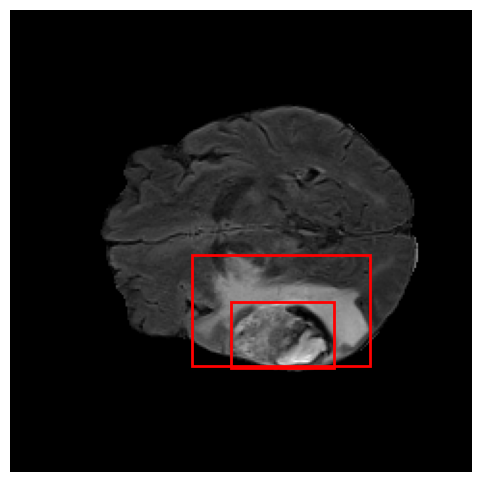

In [41]:
from ultralytics import YOLO
import cv2, matplotlib.pyplot as plt

# load trained model
model = YOLO("runs/detect/brats_yolo_subset/weights/best.pt")

# pick one val image
img_path = "/content/data/images/val/" + val_files[4][:-3] + ".png"
img = cv2.imread(img_path)
bgr = img  # already BGR
results = model.predict(source=bgr, imgsz=240, conf=0.25)

boxes = results[0].boxes.xyxy.cpu().numpy()
print("YOLO detected boxes:", boxes)

# visualize
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
for x0,y0,x1,y1 in boxes:
    plt.gca().add_patch(plt.Rectangle((x0,y0), x1-x0, y1-y0,
                                      fill=False, edgecolor='r', linewidth=2))
plt.axis("off")
plt.show()


## Refine with SAM2

In [42]:
# 1) Remove the bad checkpoint (if it exists)
!rm -f /content/sam_v2.pth

# 2) Download the correct ViT-B SAM2 checkpoint
!wget -qO /content/sam_v2.pth \
    https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

# 3) Verify it downloaded (~1.3 GB)
!ls -lh /content/sam_v2.pth


-rw-r--r-- 1 root root 358M Apr  4  2023 /content/sam_v2.pth


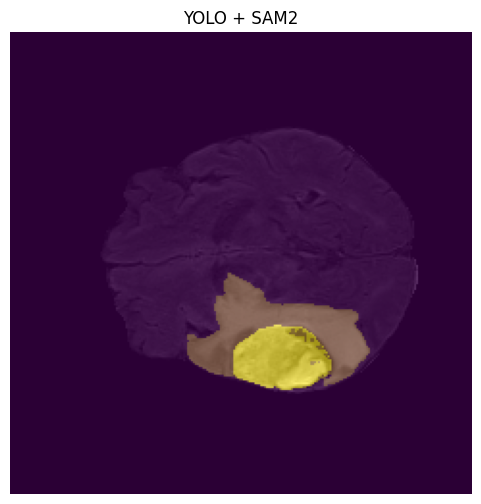

In [44]:
from segment_anything import sam_model_registry, SamPredictor
import torch, cv2, matplotlib.pyplot as plt
import numpy as np # Import numpy if not already imported elsewhere in the cell

# 1. Init SAM
sam = sam_model_registry["vit_b"](checkpoint="/content/sam_v2.pth")
device = "cuda" if torch.cuda.is_available() else "cpu"
sam.to(device)
predictor = SamPredictor(sam)

# 2. Prepare your image & boxes (from YOLO)
# The image and boxes variables should be available from the previous cell execution
# Ensure 'img' and 'boxes' are defined. If not, re-run the previous cell.
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
predictor.set_image(rgb)

# 3. Predict masks
masks = [] # Initialize an empty list to store masks
scores = [] # Initialize an empty list to store scores

# Check if any boxes were detected by YOLO
if boxes.shape[0] > 0:
    # Process each box individually with SAM
    for box in boxes:
        mask, score, _ = predictor.predict(
            point_coords=None,
            box=box[np.newaxis,:], # SAM expects box as shape (1, 4)
            multimask_output=False
        )
        masks.append(mask[0]) # Append the single mask from the result
        scores.append(score[0]) # Append the single score from the result

else:
    print("No boxes detected by YOLO for this image. Skipping SAM prediction.")
    # Optionally, handle the case where no boxes are found,
    # e.g., create an empty mask or a full background mask.
    # For now, we'll just have empty masks and scores lists.


# 4. Visualize
plt.figure(figsize=(6,6))
plt.imshow(rgb)
# Only attempt to plot masks if there are any
if len(masks) > 0:
    # Plot each mask returned by SAM
    for mask in masks:
        plt.imshow(mask, alpha=0.4)
plt.axis("off")
plt.title("YOLO + SAM2")
plt.show()

In [45]:
# Recursively list your runs directory
!ls -R runs


runs:
detect

runs/detect:
brats_yolo_subset  val	val2  val3

runs/detect/brats_yolo_subset:
args.yaml			 PR_curve.png	   val_batch0_labels.jpg
confusion_matrix_normalized.png  R_curve.png	   val_batch0_pred.jpg
confusion_matrix.png		 results.csv	   val_batch1_labels.jpg
F1_curve.png			 results.png	   val_batch1_pred.jpg
labels_correlogram.jpg		 train_batch0.jpg  val_batch2_labels.jpg
labels.jpg			 train_batch1.jpg  val_batch2_pred.jpg
P_curve.png			 train_batch2.jpg  weights

runs/detect/brats_yolo_subset/weights:
best.pt  last.pt

runs/detect/val:
confusion_matrix_normalized.png  PR_curve.png		val_batch1_labels.jpg
confusion_matrix.png		 R_curve.png		val_batch1_pred.jpg
F1_curve.png			 val_batch0_labels.jpg	val_batch2_labels.jpg
P_curve.png			 val_batch0_pred.jpg	val_batch2_pred.jpg

runs/detect/val2:
val_batch0_labels.jpg  val_batch1_labels.jpg  val_batch2_labels.jpg
val_batch0_pred.jpg    val_batch1_pred.jpg    val_batch2_pred.jpg

runs/detect/val3:
confusion_matrix_normalized.png 

In [46]:
!yolo val \
    model=runs/detect/brats_yolo_subset/weights/best.pt \
    data=/content/data.yaml \
    batch=4 \
    imgsz=240


WARNING ⚠️ imgsz=[240] must be multiple of max stride 32, updating to [256]
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 208.0±116.4 MB/s, size: 4.3 KB)
val: Scanning /content/data/labels/val.cache... 5148 images, 2974 backgrounds, 0 corrupt: 100% 5148/5148 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1287/1287 [00:30<00:00, 42.06it/s]
                   all       5148       4810      0.579      0.521      0.518      0.287
            WholeTumor       1369       1369      0.509       0.36      0.375      0.157
             TumorCore       2151       2151      0.751      0.773      0.801      0.531
        EnhancingTumor       1290       1290      0.479      0.429      0.377      0.173
Speed: 0.1ms preprocess, 3.2ms inference, 0.0ms loss, 0.8ms postprocess


0: 256x256 (no detections), 20.8ms
Speed: 1.4ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 256)
No boxes detected by YOLO for volume_204_slice_143.h5. Skipping SAM refinement for this image.

0: 256x256 2 TumorCores, 7.2ms
Speed: 0.8ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 8.5ms
Speed: 1.1ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)
No boxes detected by YOLO for volume_38_slice_134.h5. Skipping SAM refinement for this image.

0: 256x256 1 TumorCore, 6.6ms
Speed: 0.8ms preprocess, 6.6ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 256)


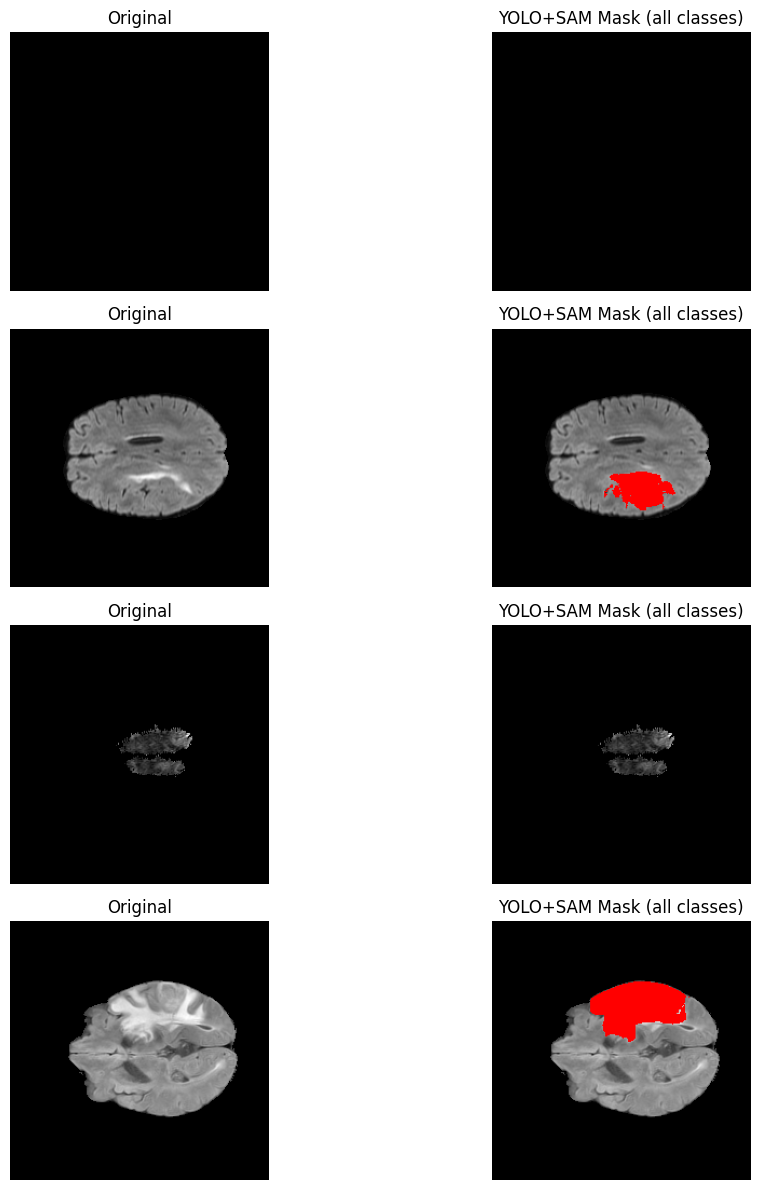

In [48]:
import random, os, cv2, numpy as np
import matplotlib.pyplot as plt
from segment_anything import SamPredictor
from ultralytics import YOLO # Import YOLO if not already imported elsewhere in the cell

# Assuming 'model' is the YOLO model loaded in a previous cell,
# e.g., model = YOLO("runs/detect/brats_yolo_subset/weights/best.pt")
# Also assuming 'sam' and 'predictor' are initialized SAM objects from a previous cell.
# If not, you need to initialize them here or ensure the cells defining them are run.

# Sample 4 random validation images
# Ensure val_files is defined (from train/val split cell)
samples = random.sample(val_files, k=4)
plt.figure(figsize=(12,12))

for i, fname in enumerate(samples, 1):
    # Load image
    img_path = f"/content/data/images/val/{fname[:-3]}.png"
    img_bgr  = cv2.imread(img_path)
    rgb      = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # YOLO detection (all classes)
    # Use the 'model' variable that was defined when loading the YOLO weights
    res   = model.predict(source=img_bgr, imgsz=256, conf=0.25)[0]
    boxes = res.boxes.xyxy.cpu().numpy()

    # SAM refine each box & union them
    # Ensure 'predictor' is already initialized with the SAM model
    predictor.set_image(rgb)
    union_mask = np.zeros(rgb.shape[:2], dtype=bool)

    # Check if any boxes were detected by YOLO before trying to refine with SAM
    if boxes.shape[0] > 0:
        for box in boxes:
            mask, _, _ = predictor.predict(point_coords=None,
                                           box=box[np.newaxis,:],
                                           multimask_output=False)
            # Ensure mask is not None or empty before ORing
            if mask is not None and mask.shape[0] > 0:
                union_mask |= mask[0].astype(bool)
    else:
        print(f"No boxes detected by YOLO for {fname}. Skipping SAM refinement for this image.")


    # Overlay mask in red
    overlay = rgb.copy()
    # Only apply overlay if union_mask has true values
    if np.any(union_mask):
        overlay[union_mask] = [255, 0, 0]  # red


    # Plot original & overlay
    plt.subplot(4, 2, 2*i-1)
    plt.imshow(rgb); plt.title("Original"); plt.axis("off")

    plt.subplot(4, 2, 2*i)
    plt.imshow(overlay); plt.title("YOLO+SAM Mask (all classes)"); plt.axis("off")

plt.tight_layout()
plt.show()

## Dependencies

In [49]:
!pip install --quiet \
    kagglehub ultralytics segment-anything \
    torch torchvision --extra-index-url https://download.pytorch.org/whl/cu124 \
    opencv-python matplotlib scikit-learn nibabel h5py


## Imports & Hyperparameters

In [50]:
import os, subprocess, glob, h5py, cv2, argparse
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor

# Paths & hyperparameters (tweak these as needed)
DATA_YAML   = "/content/data.yaml"
YOLO_MODEL  = "yolov8n.pt"
EPOCHS      = 20
BATCH       = 4
IMGSZ       = 256
CONF_THRESH = 0.25
RUN_NAME    = "brats_yolo_full"
SAM_CKPT    = "/content/sam_v2.pth"
OUT_DIR     = "/content/outputs"
DATA_H5_DIR = "/content/sample_data/brats2020-training-data/BraTS2020_training_data/content/data"
IMAGES_VAL  = "/content/data/images/val"


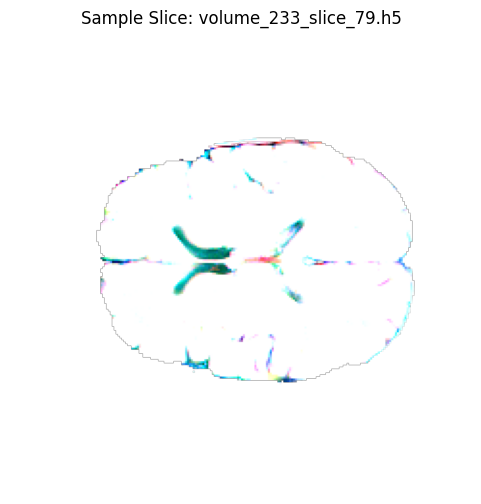

In [57]:
plt.figure(figsize=(6, 6))
plt.imshow(image_data, cmap='gray')
plt.title(f"Sample Slice: {os.path.basename(sample_file)}")
plt.axis('off')
plt.show()

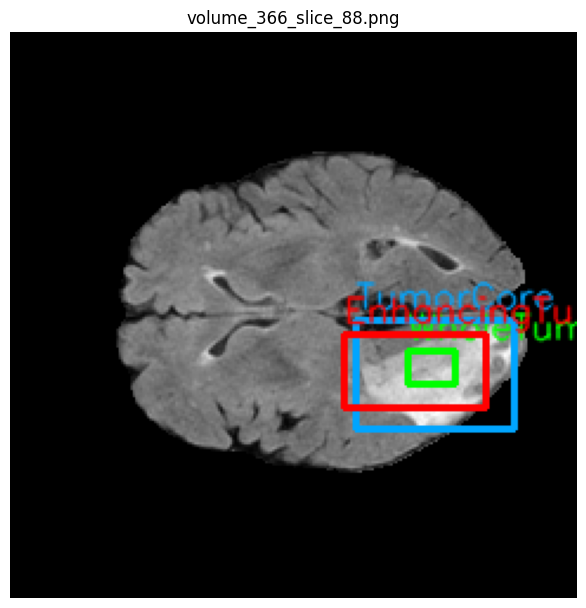

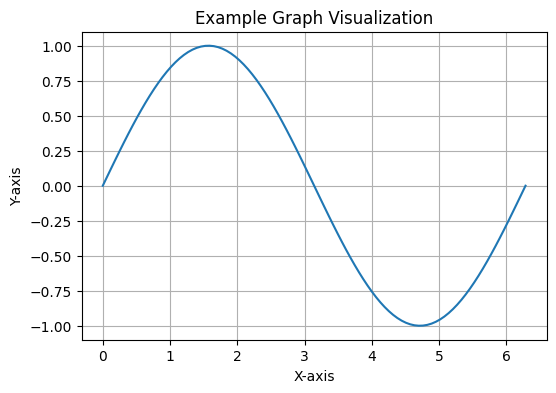

In [74]:
plt.figure(figsize=(12,12))
# ... code to draw boxes ...
plt.subplot(2,2,i)
plt.imshow(disp) # disp contains the image with drawn boxes
plt.title(img_name)
plt.axis('off')
# ... more plotting ...
plt.tight_layout()
plt.show()

# You can add code to visualize a graph here.
# For example, to plot a simple sine wave:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)

plt.figure(figsize=(6, 4))
plt.plot(x, y)
plt.title("Example Graph Visualization")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.show()

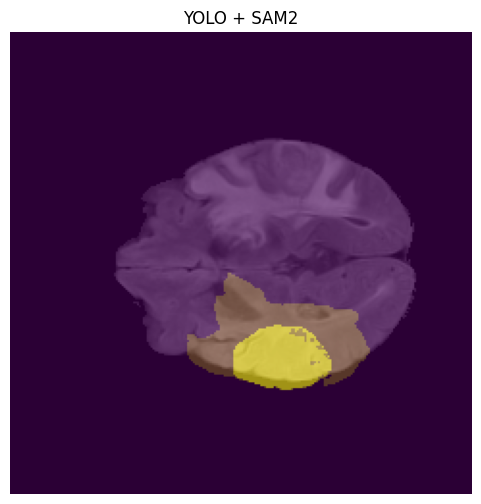

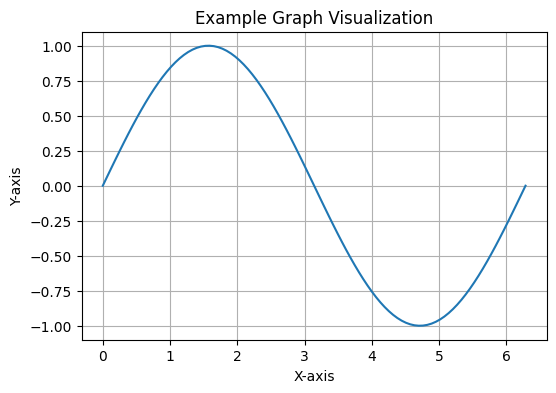

In [73]:
plt.figure(figsize=(6,6))
plt.imshow(rgb) # original image
if len(masks) > 0:
    for mask in masks:
        plt.imshow(mask, alpha=0.4) # overlaid mask
plt.axis("off")
plt.title("YOLO + SAM2")
plt.show()

# You can add code to visualize a graph here.
# For example, to plot a simple sine wave:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)

plt.figure(figsize=(6, 4))
plt.plot(x, y)
plt.title("Example Graph Visualization")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.show()

In [72]:
import os
import pandas as pd
import matplotlib.pyplot as plt

#Ensure these are defined, e.g., from your 'Imports & Hyperparameters' cell
DATA_YAML   = "/content/data.yaml"
YOLO_MODEL  = "yolov8n.pt"
EPOCHS      = 10
BATCH       = 4
IMGSZ       = 256
CONF_THRESH = 0.25
RUN_NAME    = "brats_yolo_full" # Or whatever name you used in !yolo train
SAM_CKPT    = "/content/sam_v2.pth"
OUT_DIR     = "/content/outputs"
DATA_H5_DIR = "/content/sample_data/brats2020-training-data/BraTS2020_training_data/content/data"
IMAGES_VAL  = "/content/data/images/val"


def plot_training_curves():
    print("Attempting to plot training curves...") # Check if function is entered
    run_dir = f"runs/detect/{RUN_NAME}"
    results_path = os.path.join(run_dir, 'results.csv')

    print(f"Looking for results file at: {results_path}") # Check the path

    if not os.path.exists(results_path):
        print(f"Error: Results file not found at {results_path}")
        print("Please ensure the YOLO training command (!yolo train ...) ran successfully.")
        print(f"Check the directory: !ls {run_dir}") # Suggest checking the directory
        return # Stop execution if file not found

    try:
        df = pd.read_csv(results_path)
        print(f"Successfully read results file. DataFrame shape: {df.shape}") # Check if file was read
        print(f"DataFrame columns: {list(df.columns)}") # Check column names

        if df.empty:
            print("Warning: Results file is empty. No data to plot.")
            return # Stop if no data

        # Check for required columns before plotting
        required_loss_cols = ['epoch', 'box_loss', 'cls_loss', 'dfl_loss']
        required_map_cols = ['epoch', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95']

        # Plot Losses
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        # Check if columns exist before plotting to prevent KeyError
        for col in ['box_loss', 'cls_loss', 'dfl_loss']:
            if col in df.columns:
                plt.plot(df['epoch'], df[col], label=col)
            else:
                print(f"Warning: Loss column '{col}' not found in results.csv")

        plt.title('YOLO Loss'); plt.xlabel('Epoch'); plt.legend()
        plt.grid(True) # Add grid for better readability

        # Plot mAP
        plt.subplot(1, 2, 2)
        # Check if columns exist before plotting
        if 'metrics/mAP_0.5' in df.columns:
            plt.plot(df['epoch'], df['metrics/mAP_0.5'], label='mAP@0.5')
        else:
            print("Warning: mAP@0.5 column not found in results.csv")

        if 'metrics/mAP_0.5:0.95' in df.columns:
            plt.plot(df['epoch'], df['metrics/mAP_0.5:0.95'], label='mAP@0.5:0.95')
        else:
             print("Warning: mAP@0.5:0.95 column not found in results.csv")

        plt.title('YOLO mAP'); plt.xlabel('Epoch'); plt.legend()
        plt.grid(True) # Add grid for better readability

        plt.tight_layout()

        # Ensure OUT_DIR exists before saving
        if not os.path.exists(OUT_DIR):
            os.makedirs(OUT_DIR)
            print(f"Created output directory: {OUT_DIR}")

        save_path = os.path.join(OUT_DIR, 'training_curves.png')
        plt.savefig(save_path)
        print(f"Saved training curves plot to: {save_path}")

        plt.show() # Display the plot
        print("Plots should be displayed above.")


    except FileNotFoundError:
        # This case is handled by the os.path.exists check above, but good practice
        print(f"Error: File not found - {results_path}")
    except KeyError as e:
        print(f"Error: Missing expected column in results.csv - {e}")
        print(f"Available columns: {list(df.columns)}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


# Add a cell *after* the function definition cell containing just:
# plot_training_curves()

# Or add this line immediately after the function definition
plot_training_curves()

Attempting to plot training curves...
Looking for results file at: runs/detect/brats_yolo_full/results.csv
Error: Results file not found at runs/detect/brats_yolo_full/results.csv
Please ensure the YOLO training command (!yolo train ...) ran successfully.
Check the directory: !ls runs/detect/brats_yolo_full
